### Ray AI Runtime: An end-to-end for image classification example

[Ray AI Runtime (AIR)](https://docs.ray.io/en/latest/ray-air/getting-started.html) is a scalable and unified toolkit for machine learning (ML) applications. AIR enables simple scaling of individual workloads and end-to-end workflows using popular ML frameworks, all in just Python.

AIR builds on Ray’s best-in-class libraries for [Preprocessing](https://docs.ray.io/en/latest/data/dataset.html#datasets), [Training](https://docs.ray.io/en/latest/train/train.html#train-docs), [Tuning](https://docs.ray.io/en/latest/tune/index.html#tune-main), [Scoring](https://docs.ray.io/en/latest/ray-air/predictors.html#air-predictors), [Serving](https://docs.ray.io/en/latest/serve/index.html#rayserve), and [Reinforcement Learning](https://docs.ray.io/en/latest/rllib/index.html#rllib-index) to bring together an ecosystem of integrations. 

Out of the box with Ray AIR, you can easily build the common machine line pipeline with AIR's components.

<img src="images/air_ml_workflow.png" width="60%" height="30%">

This notebook employs each of these components to illustrate how in six distinct steps, using each of the Ray AIR [components and its APIs](https://docs.ray.io/en/latest/ray-air/package-ref.html#ray-air-api), to build a common ML pipeline for an image classification.


### The CIFAR-10 dataset for classification

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

<img src="images/cifar-10.png" width="60%" height="30%">

[Cifar-10 source](https://www.cs.toronto.edu/~kriz/cifar.html)

### Learning objectives

  * Use AIR's PyTorch Trainers, Tuners, Checkpoint, Batch & Online inference predictors
  * Understand how Ray data integrates with Ray AIR for data ingestion and prediction
  * Use out-of-box Preprocessors
  * Load model from the best model checkpoint and use for batch inference
  * Deploy best checkpoint model and use for online inference
  * Using all the Ray discrete components to write an end-to-end ML application in a single Python script
  * Use PyTorch for data distributed training (DDP)

In [1]:
import ray

from ray import serve
from ray.serve import PredictorDeployment
 
import cifar_utils

from ray.train.torch import TorchTrainer
from ray.tune import Tuner
from ray.tune import TuneConfig
from ray.air.config import RunConfig
from ray.air.config import ScalingConfig
from ray.air.config import CheckpointConfig

from ray.train.torch import TorchPredictor
from ray.train.batch_predictor import BatchPredictor

import torch
import numpy as np
import pandas as pd
import requests

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-01-03 10:42:52,924	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.2.0
Dashboard:,http://127.0.0.1:8265


In [3]:
ray.cluster_resources()

{'CPU': 10.0,
 'object_store_memory': 2147483648.0,
 'node:127.0.0.1': 1.0,
 'memory': 49890859418.0}

### Step 1. Fetch Data

Use Ray data to fetch data from a data source. Here we use a simple built-in `SimpleTorchDatasouce`. For preprocessing needs, such as scaling or normalizing, 
Ray AIR provides a host of preprocessors you can use; these [preprocessors](https://docs.ray.io/en/latest/ray-air/preprocessors.html) can be supplied downstream to `Trainers` and `BatchPredictors` to preprocess your 
input before training, tuning, or scoring, relieving you the onus of doing it yourself. 

<img src="images/data_prep.png" width="360%" height="30%">

In [4]:
train_torchvision_dataset = cifar_utils.train_dataset_factory()
test_torchvision_dataset = cifar_utils.test_dataset_factory()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_torchvision_dataset, type(train_torchvision_dataset) 

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: /Users/jules/data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 torchvision.datasets.cifar.CIFAR10)

**Note**: The above are PyTorch torchvision data types. We want to convert
them into Ray Dataset types.

### Step 2: Create a preprocessor to transform data
* Convert Torchvisiion data into Ray data
* Transform data into Pandas DataFrame because internally Ray data uses Pandas by default as it internal representation
* Use dataset `map_batches`() to convert 

In [6]:
train_dataset: ray.data.Dataset = ray.data.from_torch(train_torchvision_dataset)
test_dataset: ray.data.Dataset = ray.data.from_torch(test_torchvision_dataset)
train_dataset, type(train_dataset)

(Dataset(num_blocks=200, num_rows=50000, schema=<class 'tuple'>),
 ray.data.dataset.Dataset)

In [7]:
train_dataset = train_dataset.map_batches(cifar_utils.convert_batch_to_numpy)
test_dataset = test_dataset.map_batches(cifar_utils.convert_batch_to_numpy)
train_dataset, type(train_dataset)

Map_Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 646.90it/s]


(Dataset(num_blocks=200, num_rows=50000, schema={image: ArrowTensorType(shape=(3, 32, 32), dtype=float), label: int64}),
 ray.data.dataset.Dataset)

### Step 3: Create a `TorchTrainer` for PyTorch DDP training
This trainer is then fed into tuner for doing some hyper-parameter optimization. Ray AIR supports popular [Trainers](https://docs.ray.io/en/latest/ray-air/trainer.html)
for the common ML libraries: PyTorch, TensorFlow, XGBoost, scikit-learn. These can be used alongside [Tuner](https://docs.ray.io/en/latest/ray-air/tuner.html)

<img src="images/trainer.png" width="60%" height="30%">

In [8]:
trainer = TorchTrainer(train_loop_per_worker=cifar_utils.train_loop_per_worker,
                        datasets={"train": train_dataset},
                        scaling_config=ScalingConfig(num_workers=4, use_gpu=False), # change to True if on GPU
)

### Step 4: Create the Tuner 

Tuning a model over a hyperparameters space is a common workload and paramount to get better accuracy. Here we tune the relevant tune configuration such as `lr`, `batch_size`, `epochs`.
However, you can use SOTA [search algorithms](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html) and [schedulers](https://docs.ray.io/en/latest/tune/api_docs/schedulers.html) alongside [Tuner](https://docs.ray.io/en/latest/tune/api_docs/execution.html#ray.tune.Tuner) to control your trials, depending on your model requirements and desired results.


<img src="images/tuner.png" width="60%" height="30%">

In [9]:
tuner = Tuner(trainer,
        param_space={
            "train_loop_config": {
                "lr": ray.tune.grid_search([0.01]),
                "epochs": 10, "batch_size": 32,
                "verbose": 1}
        },
        # specific tune metrics to collect and checkpoint
        # during trials
        tune_config=TuneConfig(metric="train_loss", mode="min"),
        run_config=RunConfig(checkpoint_config=CheckpointConfig(num_to_keep=1, 
                        checkpoint_score_attribute="train_loss", 
                        checkpoint_score_order="min")
        )
    )

Once we have set up our Trainer and Tuner, all we need to create distributed training and trials is use the 
familiar API .`.fit`() to launch our distributed trainiing and tuning.

In [10]:
# Run the tuner, which will call trainer for each trial with
# the parameters configurations as part of it HPO and trains it in parallel
# with a shard of its own data. This is distributed training and tunning in parallel

results = tuner.fit()

(RayTrainWorker pid=10775) 2023-01-03 10:43:39,945	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=4]
(RayTrainWorker pid=10777) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=10776) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=10778) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(RayTrainWorker pid=10775) [W ProcessGroupGloo.cpp:724] Warning: Unable to resolve hostname to a (local) address. Using the loo

(RayTrainWorker pid=10777) Training epoch:1/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10776) Training epoch:1/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10778) Training epoch:1/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10775) Training epoch:1/10 | batch_size:32 | lr:0.01


  0%|          | 0/10 [00:00<?, ?it/s]m 
(RayTrainWorker pid=10775) 2023-01-03 10:43:41,347	INFO train_loop_utils.py:270 -- Moving model to device: cpu
(RayTrainWorker pid=10775) 2023-01-03 10:43:41,347	INFO train_loop_utils.py:330 -- Wrapping provided model in DistributedDataParallel.
  0%|          | 0/10 [00:00<?, ?it/s]m 


(RayTrainWorker pid=10778) Training epoch:2/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10777) Training epoch:2/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10776) Training epoch:2/10 | batch_size:32 | lr:0.01


 10%|█         | 1/10 [09:13<1:23:00, 553.44s/it]


Trial name,_time_this_iter_s,_timestamp,_training_iteration,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train_loss,training_iteration,trial_id,warmup_time
TorchTrainer_87c5f_00000,508.894,1672778802,10,2023-01-03_12-46-43,True,,de721e5d2d1b403496aadae5bdc1b7cd,0_lr=0.0100,Juless-MacBook-Pro-16,10,127.0.0.1,10767,True,7385.29,508.857,7385.29,1672778803,0,,0.163446,10,87c5f_00000,0.31948


(RayTrainWorker pid=10775) Training epoch:2/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10777) Training epoch:3/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10776) Training epoch:3/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10778) Training epoch:3/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10775) Training epoch:3/10 | batch_size:32 | lr:0.01


 20%|██        | 2/10 [32:24<2:19:30, 1046.32s/it]


(RayTrainWorker pid=10777) Training epoch:4/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10776) Training epoch:4/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10778) Training epoch:4/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10775) Training epoch:4/10 | batch_size:32 | lr:0.01


 30%|███       | 3/10 [40:53<1:33:24, 800.69s/it] 


(RayTrainWorker pid=10777) Training epoch:5/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10776) Training epoch:5/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10778) Training epoch:5/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10775) Training epoch:5/10 | batch_size:32 | lr:0.01


 40%|████      | 4/10 [49:20<1:08:30, 685.03s/it]


(RayTrainWorker pid=10777) Training epoch:6/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10776) Training epoch:6/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10778) Training epoch:6/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10775) Training epoch:6/10 | batch_size:32 | lr:0.01


 50%|█████     | 5/10 [57:52<51:52, 622.48s/it]  


(RayTrainWorker pid=10777) Training epoch:7/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10776) Training epoch:7/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10778) Training epoch:7/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10775) Training epoch:7/10 | batch_size:32 | lr:0.01


 60%|██████    | 6/10 [1:11:20<45:42, 685.61s/it]


(RayTrainWorker pid=10777) Training epoch:8/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10776) Training epoch:8/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10778) Training epoch:8/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10775) Training epoch:8/10 | batch_size:32 | lr:0.01


 70%|███████   | 7/10 [1:19:46<31:20, 626.85s/it]


(RayTrainWorker pid=10777) Training epoch:9/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10776) Training epoch:9/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10778) Training epoch:9/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10775) Training epoch:9/10 | batch_size:32 | lr:0.01


 80%|████████  | 8/10 [1:46:02<30:58, 929.15s/it]


(RayTrainWorker pid=10777) Training epoch:10/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10776) Training epoch:10/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10778) Training epoch:10/10 | batch_size:32 | lr:0.01
(RayTrainWorker pid=10775) Training epoch:10/10 | batch_size:32 | lr:0.01


100%|██████████| 10/10 [2:03:01<00:00, 738.17s/it]
2023-01-03 12:46:45,871	INFO tune.py:762 -- Total run time: 7390.12 seconds (7389.96 seconds for the tuning loop).


In [11]:
# Get the best checkpoint result
best_checkpoint = results.get_best_result(metric="train_loss", mode="min").checkpoint
best_checkpoint

TorchCheckpoint(local_path=/Users/jules/ray_results/TorchTrainer_2023-01-03_10-43-33/TorchTrainer_87c5f_00000_0_lr=0.0100_2023-01-03_10-43-35/checkpoint_000009)

In [12]:
best_checkpoint.to_directory("./best_checkpoint")

'best_checkpoint'

### Step 5: Use `TorchPredictor` using the `Checkpoint` object
This allows batch inference at scale:
* Test our model with [`TorchPredictor`](https://docs.ray.io/en/latest/_modules/ray/train/torch/torch_predictor.html?highlight=TorchPredictor) using the [`Checkpoint`](https://docs.ray.io/en/latest/ray-air/key-concepts.html#checkpoints) object.
* Fetch the best_checkpoint from the  checkpoint. 
* Use batch predictor to test the entire batch in one go


<img src="images/batch_predictor.png" width="60%" height="30%">

In [19]:
# drop the label column
predict_dataset = test_dataset.drop_columns(cols=["label"])

# Create our BatchPredictor from the best checkpoint obtained above after all the trials are finished
batch_predictor = BatchPredictor.from_checkpoint(
    checkpoint=best_checkpoint,
    predictor_cls=TorchPredictor,
    model=cifar_utils.ResNet18(),
    use_gpu=False # set it to True if GPU available
)

# Do prediction at scale over the entire batch
output: ray.data.Dataset = batch_predictor.predict(
    data=test_dataset, dtype=torch.float, 
    feature_columns=["image"], 
    keep_columns=["label"],
    #num_gpus_per_worker=1,
)

Map_Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 556.69it/s]
2023-01-03 12:57:57,400	WARNING compute.py:520 -- `batch_size` is set to 4096, which reduces parallelism from 200 to 3. If the performance is worse than expected, this may indicate that the batch size is too large or the input block size is too small. To reduce batch size, consider decreasing `batch_size` or use the default in `map_batches`. To increase input block size, consider decreasing `parallelism` in read.
Map Progress (10 actors 3 pending):   0%|                                                                            | 0/3 [00:13<?, ?it/s]

(scheduler +2h15m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +2h15m36s) Error: No available node types can fulfill resource request {'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


Map Progress (10 actors 3 pending):  33%|██████████████████████▋                                             | 1/3 [00:30<01:00, 30.04s/it]

(scheduler +2h16m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +2h16m11s) Error: No available node types can fulfill resource request {'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


Map Progress (10 actors 3 pending): 100%|████████████████████████████████████████████████████████████████████| 3/3 [01:29<00:00, 29.91s/it]


In [20]:
# Get the predictions from the output and convert them into classes
predictions = output.map_batches(cifar_utils.convert_logits_to_classes, batch_format="pandas")

# Get all predictions for test_dataset 
scores = predictions.map_batches(cifar_utils.calculate_prediction_scores)

# compute total prediction accuracy. That is all predictions equal to ground truth
# That is, predictated accurately.
total_acc = scores.sum(on="correct") / scores.count()

print(f"Prediction accuracy from the test data of 10,000 images: {total_acc * 100:.2f}%")

Map_Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.81it/s]


(scheduler +2h16m46s) Error: No available node types can fulfill resource request {'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


Shuffle Reduce: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.46it/s]

Prediction accuracy from the test data of 10,000 images: 82.31%


### Step 6: Online prediction
 * Deploy our model to the network for online prediction
 * Use `TorchPredictor` and [`PredictorDeployment`](https://docs.ray.io/en/latest/ray-air/package-ref.html?highlight=PredictorDeployment#ray.serve.air_integrations.PredictorDeployment) APIs
 * Start a Ray serve in detached mode, with two replicas
 
 This will automatically deploy the model from the lastest checkpoint. You can adjust num of replicas in the options.
 
 <img src="images/online_predictor.png" width="60%" height="25%">
 

In [25]:
# Start Ray Serve in detached mode so that if this application terminates, Serve can still process the incoming
# requests. 
serve.start(detached=True)

# create the PredictorDeployment and give it a name and number of replicas. Depending on your
# request loads, you can scale up the number of replicas
deployment = PredictorDeployment.options(name="cifar-deployment", num_replicas=2)
deployment.deploy(TorchPredictor, best_checkpoint, batching_params=False, model=cifar_utils.ResNet18(), http_adapter=cifar_utils.json_to_numpy)

(ServeController pid=33714) INFO 2023-01-03 13:01:39,623 controller 33714 deployment_state.py:1214 - Stopping 1 replicas of deployment 'cifar-deployment' with outdated versions.
(ServeController pid=33714) INFO 2023-01-03 13:01:41,766 controller 33714 deployment_state.py:1310 - Adding 1 replica to deployment 'cifar-deployment'.
(ServeController pid=33714) INFO 2023-01-03 13:01:43,977 controller 33714 deployment_state.py:1214 - Stopping 1 replicas of deployment 'cifar-deployment' with outdated versions.
(ServeController pid=33714) INFO 2023-01-03 13:01:46,113 controller 33714 deployment_state.py:1310 - Adding 1 replica to deployment 'cifar-deployment'.


(scheduler +2h19m6s) Error: No available node types can fulfill resource request {'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


### Test online prediction from the test data

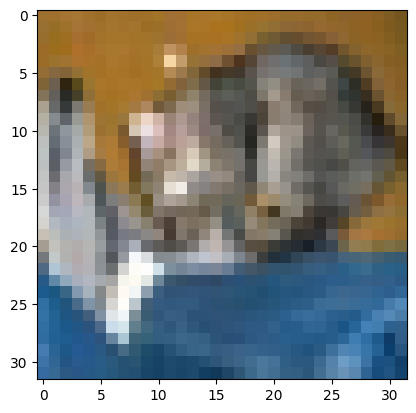

prediction: 5; class: dog; matched: False


(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,190 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 307 7.1ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,217 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 200 25.4ms
(ServeReplica:cifar-deployment pid=34211) INFO 2023-01-03 13:13:45,214 cifar-deployment cifar-deployment#LEwcMc replica.py:505 - HANDLE __call__ OK 21.5ms
(ServeReplica:cifar-deployment pid=34221) INFO 2023-01-03 13:13:45,187 cifar-deployment cifar-deployment#nICIKZ replica.py:505 - HANDLE __call__ OK 0.2ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,312 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 307 9.6ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,353 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 200 37.9ms
(ServeReplica:cifar-deployment pid=34211) INFO 2023-01-03 13:13:45,347 cifar-deployment cifar-deployment#LEwcMc replica.py:505 - HANDLE __call__ OK 22.4ms
(ServeReplica:

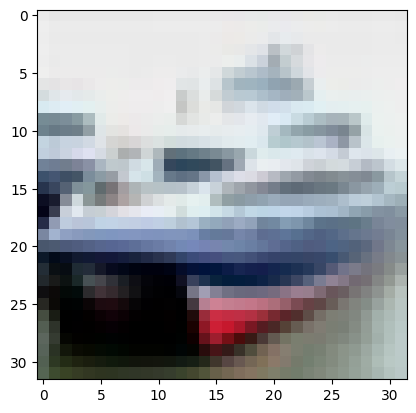

prediction: 1; class: car; matched: False


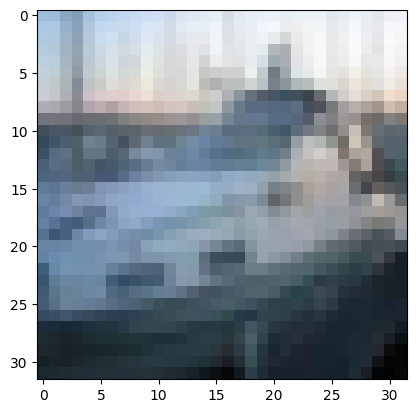

prediction: 8; class: ship; matched: True


(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,428 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 307 7.3ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,454 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 200 23.4ms
(ServeReplica:cifar-deployment pid=34211) INFO 2023-01-03 13:13:45,452 cifar-deployment cifar-deployment#LEwcMc replica.py:505 - HANDLE __call__ OK 18.5ms
(ServeReplica:cifar-deployment pid=34221) INFO 2023-01-03 13:13:45,425 cifar-deployment cifar-deployment#nICIKZ replica.py:505 - HANDLE __call__ OK 0.1ms
(ServeReplica:cifar-deployment pid=34221) INFO 2023-01-03 13:13:45,516 cifar-deployment cifar-deployment#nICIKZ replica.py:505 - HANDLE __call__ OK 0.1ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,519 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 307 3.9ms


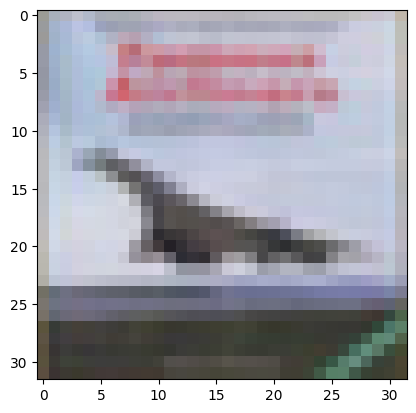

prediction: 0; class: plane; matched: True


(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,544 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 200 23.5ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,596 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 307 3.8ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,619 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 200 21.5ms
(ServeReplica:cifar-deployment pid=34211) INFO 2023-01-03 13:13:45,542 cifar-deployment cifar-deployment#LEwcMc replica.py:505 - HANDLE __call__ OK 18.6ms
(ServeReplica:cifar-deployment pid=34211) INFO 2023-01-03 13:13:45,618 cifar-deployment cifar-deployment#LEwcMc replica.py:505 - HANDLE __call__ OK 19.1ms
(ServeReplica:cifar-deployment pid=34221) INFO 2023-01-03 13:13:45,594 cifar-deployment cifar-deployment#nICIKZ replica.py:505 - HANDLE __call__ OK 0.1ms


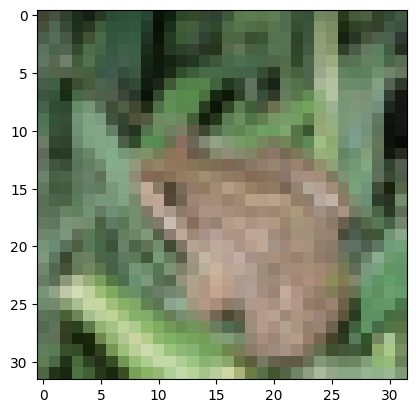

prediction: 6; class: frog; matched: True


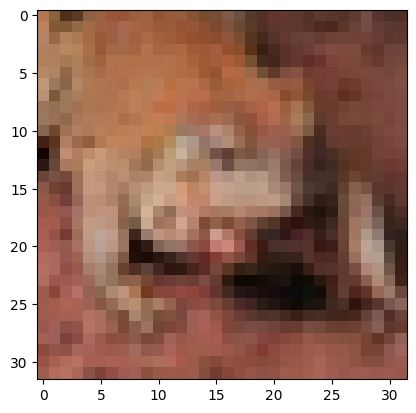

prediction: 6; class: frog; matched: True


(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,675 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 307 2.2ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,692 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 200 15.9ms
(ServeReplica:cifar-deployment pid=34211) INFO 2023-01-03 13:13:45,691 cifar-deployment cifar-deployment#LEwcMc replica.py:505 - HANDLE __call__ OK 13.9ms
(ServeReplica:cifar-deployment pid=34221) INFO 2023-01-03 13:13:45,674 cifar-deployment cifar-deployment#nICIKZ replica.py:505 - HANDLE __call__ OK 0.1ms


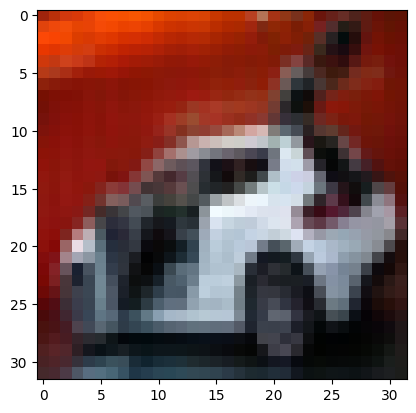

prediction: 1; class: car; matched: True


(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,749 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 307 6.1ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,771 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 200 20.4ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,829 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 307 4.5ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,847 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 200 17.1ms
(ServeReplica:cifar-deployment pid=34211) INFO 2023-01-03 13:13:45,770 cifar-deployment cifar-deployment#LEwcMc replica.py:505 - HANDLE __call__ OK 18.5ms
(ServeReplica:cifar-deployment pid=34211) INFO 2023-01-03 13:13:45,845 cifar-deployment cifar-deployment#LEwcMc replica.py:505 - HANDLE __call__ OK 12.9ms
(ServeReplica:cifar-deployment pid=34221) INFO 2023-01-03 13:13:45,745 cifar-deployment cifar-deployment#nICIKZ replica.py:505 - HANDLE __call__ OK 0.1ms
(ServeReplica:

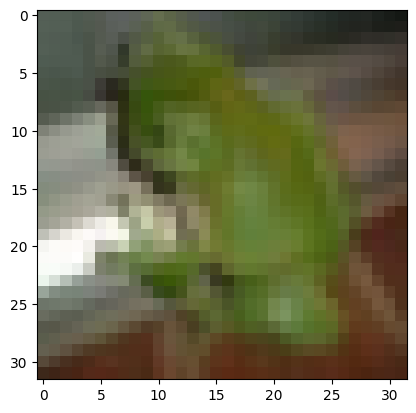

prediction: 6; class: frog; matched: True


(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,903 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 307 4.1ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,920 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 200 16.3ms
(ServeReplica:cifar-deployment pid=34211) INFO 2023-01-03 13:13:45,919 cifar-deployment cifar-deployment#LEwcMc replica.py:505 - HANDLE __call__ OK 14.4ms
(ServeReplica:cifar-deployment pid=34221) INFO 2023-01-03 13:13:45,902 cifar-deployment cifar-deployment#nICIKZ replica.py:505 - HANDLE __call__ OK 0.1ms


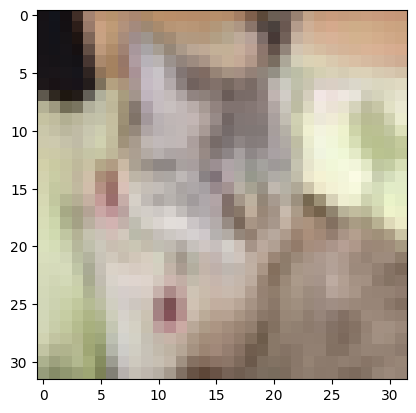

prediction: 3; class: cat; matched: True


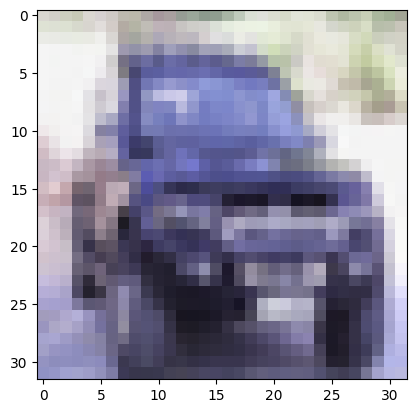

prediction: 1; class: car; matched: True


(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,979 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 307 5.4ms
(HTTPProxyActor pid=33716) INFO 2023-01-03 13:13:45,999 http_proxy 127.0.0.1 http_proxy.py:361 - POST /cifar-deployment 200 18.5ms
(ServeReplica:cifar-deployment pid=34211) INFO 2023-01-03 13:13:45,997 cifar-deployment cifar-deployment#LEwcMc replica.py:505 - HANDLE __call__ OK 14.3ms
(ServeReplica:cifar-deployment pid=34221) INFO 2023-01-03 13:13:45,975 cifar-deployment cifar-deployment#nICIKZ replica.py:505 - HANDLE __call__ OK 0.1ms


In [37]:
# Test online deployment
batch = test_dataset.take(10)
for i in range(10):
    array = np.expand_dims(np.array(batch[i]["image"]), axis=0)
    label = np.array(batch[i]["label"])
    # send request and fetch prediction
    payload  = {"array": array.tolist()}
    response = requests.post(deployment.url, json=payload).json()
    result = response["predictions"][0]
    idx, cls = cifar_utils.to_prediction_cls(result)
    matched = idx == label
    cifar_utils.img_show(batch[i]["image"])
    print(f"prediction: {idx}; class: {cls}; matched: {matched}")

In [38]:
# Shutdown our server
serve.shutdown()

(ServeController pid=33714) INFO 2023-01-03 13:14:05,701 controller 33714 deployment_state.py:1336 - Removing 2 replicas from deployment 'cifar-deployment'.


(scheduler +2h31m23s) Error: No available node types can fulfill resource request {'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(scheduler +2h31m58s) Error: No available node types can fulfill resource request {'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


### Summary

In this end-to-end ML application, you walked through a step-by-step guide on how to use Ray AIR library and its various components at each stage of an ML workflow and its respective workload: from data preprocessing and ingestion, training and tuning, to batch inference, and finaly deploying it for online inference. For this image classificaiton use case, we use PyTorch and its relevant AIR integrations such
as TorchTrainer, TorchCheckpoint, TorchPredictor, etc. AIR supports other common frameworks such as TensorFlow, XGBoost, Scikit-learn, HugginFace etc.

While we used fixed set of hyperparameters, try training and tuning with some different parameters in the exercise below.

**Note**: On single machine, an M1 Mac laptop with 10 cores, this took over 15+ hours to train. On an Anyscale Ray cluster with 4 nodes and 32 GPUs, it was matter of minutes!


### Exercises

 * Try scaling your Trainer and Tunner
  * increase the `num_workers` to 3 or 4
  * extend the tuning space 
   *  `lr=[0.001, 0.01]`
    * `epochs=[75, 100, 125]`
    * `batch_size=[64, 128]`

### Homework 
 * Read the resources below


### Resources

Here some extra reading and resources for you:
 * Watch the Ray Summit 2022 on [Introduction to Ray AIR](https://www.anyscale.com/ray-summit-2022/agenda/sessions/226)
 * Ray AIR [documentation](https://docs.ray.io/en/latest/ray-air/getting-started.html)
 * Understand its [Components and APIs](https://docs.ray.io/en/latest/ray-air/package-ref.html)
 * Ray AIR [user guides](https://docs.ray.io/en/latest/ray-air/user-guides.html) and [examples](https://docs.ray.io/en/latest/ray-air/examples/index.html) 